In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#from ydata_profiling import ProfileReport
import plotly.express as px
import plotly.graph_objects as go
import pyarrow.parquet as pq
# from google.colab import drive
# drive.mount('/content/drive')

from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import make_pipeline
from google.colab import drive
import plotly.figure_factory as ff
from sklearn.cluster import KMeans


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#funny features
def add_features(data, rolling_window = 60):
  data["harmonic1_Imaginary_var_before"] = data["harmonic1_Imaginary"].rolling(rolling_window).var()
  data["harmonic1_Imaginary_var_after"] = data.sort_index(ascending=False).rolling(rolling_window)["harmonic1_Imaginary"].var().sort_index()
  data["harmonic1_Imaginary_var_diff"] = data["harmonic1_Imaginary_var_before"] - data["harmonic1_Imaginary_var_after"]

  data["harmonic3_Imaginary_var_before"] = data["harmonic3_Imaginary"].rolling(rolling_window).var()
  data["harmonic3_Imaginary_var_after"] = data.sort_index(ascending=False).rolling(rolling_window)["harmonic3_Imaginary"].var().sort_index()
  data["harmonic3_Imaginary_var_diff"] = data["harmonic3_Imaginary_var_before"] - data["harmonic3_Imaginary_var_after"]
  data["harmonic5_Imaginary_var_before"] = data["harmonic5_Imaginary"].rolling(rolling_window).var()
  data["harmonic5_Imaginary_var_after"] = data.sort_index(ascending=False).rolling(rolling_window)["harmonic5_Imaginary"].var().sort_index()
  data["harmonic5_Imaginary_var_diff"] = data["harmonic5_Imaginary_var_before"] - data["harmonic5_Imaginary_var_after"]
  data["harmonic7_Imaginary_var_before"] = data["harmonic7_Imaginary"].rolling(rolling_window).var()
  data["harmonic7_Imaginary_var_after"] = data.sort_index(ascending=False).rolling(rolling_window)["harmonic7_Imaginary"].var().sort_index()
  data["harmonic7_Imaginary_var_diff"] = data["harmonic7_Imaginary_var_before"] - data["harmonic7_Imaginary_var_after"]


  return data


In [ ]:

# nilm_data = pd.read_csv("/content/drive/MyDrive/25day_dataset.csv")

nilm_data = pd.read_parquet('/content/drive/My Drive/105_days.parquet')
nilm_data[[col for col in nilm_data.columns if col != "DateTime"]] = nilm_data[[col for col in nilm_data.columns if col != "DateTime"]].astype(np.float32)

nilm_data["DateTime"] = nilm_data["DateTime"].astype("datetime64[ns]")
nilm_data = nilm_data.set_index("DateTime")
nilm_data["washing_machine"] = nilm_data["wahing_machine"]
# nilm_data = add_features(nilm_data)

In [ ]:
#encode appliance states
nilm_data["oven_state"] = nilm_data["oven"] > 0
nilm_data["dishwasher_state"] = nilm_data["dishwasher"] > 0
nilm_data["washing_machine_state"] = nilm_data["washing_machine"] > 0

In [ ]:
#scale data

scaler = MinMaxScaler()
scaled_nilm_data = nilm_data
scaled_features = scaler.fit_transform(scaled_nilm_data)
scaled_nilm_data = pd.DataFrame(scaled_features, index=scaled_nilm_data.index, columns = nilm_data.columns)
scaled_nilm_data = scaled_nilm_data.diff(3)
scaled_nilm_data = add_features(scaled_nilm_data)
scaled_nilm_data["oven_state"] = nilm_data["oven_state"]
scaled_nilm_data["dishwasher_state"] = nilm_data["dishwasher_state"]
scaled_nilm_data["washing_machine_state"] = nilm_data["washing_machine_state"]

In [ ]:
threshold_to_find = .2
#get ap jumps
app_jumps_on = scaled_nilm_data[scaled_nilm_data["ActivePower"] > threshold_to_find]
app_jumps_on.drop(app_jumps_on["ActivePower"].index.to_series().diff().dropna()[app_jumps_on.index.to_series().diff().dt.total_seconds().fillna(0) < 3].index, inplace=True)
app_jumps_on["oven_jump_on"] = app_jumps_on["oven"] > .5
app_jumps_on["dishwasher_jump_on"] = app_jumps_on["dishwasher"] > .5
app_jumps_on["washing_machine_jump_on"] = app_jumps_on["washing_machine"] > .5



# app_jumps_on.drop(app_jumps_on["oven_jump_on"].index.to_series().diff().dropna()[app_jumps_on["oven_jump"].index.to_series().diff().dt.total_seconds().fillna(0) < 10].index, inplace=True)
# app_jumps_on.drop(app_jumps_on["dishwasher_jump_on"].index.to_series().diff().dropna()[app_jumps_on["dishwasher_jump"].index.to_series().diff().dt.total_seconds().fillna(0) < 10].index, inplace=True)
# app_jumps_on.drop(app_jumps_on["washing_machine_jump_on"].index.to_series().diff().dropna()[app_jumps_on["washing_machine_jump"].index.to_series().diff().dt.total_seconds().fillna(0) < 10].index, inplace=True)




In [ ]:
app_jumps_off = scaled_nilm_data[scaled_nilm_data["ActivePower"] < -threshold_to_find]
app_jumps_off.drop(app_jumps_off["ActivePower"].index.to_series().diff().dropna()[app_jumps_off.index.to_series().diff().dt.total_seconds().fillna(0) < 3].index, inplace=True)
app_jumps_off["oven_jump_off"] = app_jumps_off["oven"] < -.5
app_jumps_off["dishwasher_jump_off"] = app_jumps_off["dishwasher"] < -.5
app_jumps_off["washing_machine_jump_off"] = app_jumps_off["washing_machine"] < -.5

# cluster viz

In [ ]:
x_feature = "harmonic3_Imaginary_var_diff"
y_feature = "harmonic5_Imaginary_var_diff"
z_feature = "ActivePower"

dw_only = app_jumps_on["dishwasher_jump_on"] == True
ov_only = app_jumps_on["oven_jump_on"] == True
wm_only = app_jumps_on["washing_machine_jump_on"] == True
others = (~ov_only) & (~wm_only) & (~dw_only)


fig = px.scatter_3d(x = app_jumps_on[dw_only][x_feature], y=app_jumps_on[dw_only][y_feature],
                    z=app_jumps_on[dw_only][z_feature], opacity=.5)
fig.update_traces(marker_size = 1.8)
fig2 = go.Figure(data=[go.Scatter3d(x = app_jumps_on[ov_only][x_feature], y=app_jumps_on[ov_only][y_feature],
                   z=app_jumps_on[ov_only][z_feature],
                                   mode='markers', marker = {'color' : 'red', "opacity" : .5, "size": 1.8})])
fig4 = go.Figure(data=[go.Scatter3d(x = app_jumps_on[wm_only][x_feature], y=app_jumps_on[wm_only][y_feature],
                   z=app_jumps_on[wm_only][z_feature],
                                   mode='markers', marker = {'color' : 'yellow', "opacity" : .5, "size": 3})])

fig3 = go.Figure(data=[go.Scatter3d(x = app_jumps_on[others][x_feature], y=app_jumps_on[others][y_feature],
                   z=app_jumps_on[others][z_feature],
                                   mode='markers', marker = {'color' : 'green', "opacity" : .5, "size":1.5})])
fig2.add_traces(fig3.data)
fig2.add_traces(fig4.data)
fig2.add_traces(fig.data)

# fig.add_scatter_3d(x = diff1_nilm_data[ov_only]["ActivePower"], y=diff1_nilm_data[diff1_nilm_data["oven_state"] == True]["ReactivePower"],
                  #  z=diff1_nilm_data[diff1_nilm_data["oven_state"] == True]["harmonic7_Imaginary"])

# Train

In [ ]:
dw_only = app_jumps_on["dishwasher_jump_on"] == True
ov_only = app_jumps_on["oven_jump_on"] == True
wm_only = app_jumps_on["washing_machine_jump_on"] == True
others = (~ov_only) & (~wm_only) & (~dw_only)
train_on = pd.concat([app_jumps_on[dw_only].iloc[0:50].reset_index(),
                  app_jumps_on[ov_only].iloc[0:50].reset_index(),
                   app_jumps_on[others].iloc[0:50].reset_index()])
print(len(app_jumps_on[dw_only]))
print(len(app_jumps_on[ov_only]))

feature_cols = ["harmonic1_Imaginary", "harmonic1_Imaginary_var_diff","ActivePower", "harmonic3_Imaginary", "harmonic3_Imaginary_var_diff", "harmonic5_Imaginary", "harmonic5_Imaginary_var_diff", "ReactivePower"]

dw_only = app_jumps_on["dishwasher_jump_on"] == True
ov_only = app_jumps_on["oven_jump_on"] == True
wm_only = app_jumps_on["washing_machine_jump_on"] == True

X = train_on[feature_cols]
y = train_on["oven_jump_on"]*2 + train_on["dishwasher_jump_on"]


from sklearn.neighbors import KNeighborsClassifier
neigh_on = KNeighborsClassifier(n_neighbors=3)
neigh_on.fit(X, y)


test_others = app_jumps_on[others][feature_cols]
test_ov = app_jumps_on[ov_only][feature_cols]
test_dw = app_jumps_on[dw_only][feature_cols]


other_p = neigh_on.predict(test_others)
ov_p = neigh_on.predict(test_ov)
dw_p = neigh_on.predict(test_dw)
tr = neigh_on.predict(train_on[feature_cols])

# print(dw_p, len(test_dw))
# print(ov_p, len(test_ov))
# print(other_p, len(other_p))
# print(tr, len(train_on))



258
456


In [ ]:
dw_only = app_jumps_off["dishwasher_jump_off"] == True
ov_only = app_jumps_off["oven_jump_off"] == True
wm_only = app_jumps_off["washing_machine_jump_off"] == True
others = (~ov_only) & (~wm_only) & (~dw_only)
train_off = pd.concat([app_jumps_off[dw_only].iloc[0:50].reset_index(),
                  app_jumps_off[ov_only].iloc[0:50].reset_index(),
                   app_jumps_off[others].iloc[0:50].reset_index()])
# print(len(app_jumps_off[dw_only]))
# print(len(app_jumps_off[ov_only]))

feature_cols = ["harmonic1_Imaginary", "harmonic1_Imaginary_var_diff","ActivePower", "harmonic3_Imaginary", "harmonic3_Imaginary_var_diff", "harmonic5_Imaginary", "harmonic5_Imaginary_var_diff", "ReactivePower"]

dw_only = app_jumps_off["dishwasher_jump_off"] == True
ov_only = app_jumps_off["oven_jump_off"] == True
wm_only = app_jumps_off["washing_machine_jump_off"] == True

X = train_off[feature_cols]
y = train_off["oven_jump_off"]*2 + train_off["dishwasher_jump_off"]


from sklearn.neighbors import KNeighborsClassifier
neigh_off = KNeighborsClassifier(n_neighbors=3)
neigh_off.fit(X, y)


test_others = app_jumps_off[others][feature_cols]
test_ov = app_jumps_off[ov_only][feature_cols]
test_dw = app_jumps_off[dw_only][feature_cols]


other_p = neigh_off.predict(test_others)
ov_p = neigh_off.predict(test_ov)
dw_p = neigh_off.predict(test_dw)
tr = neigh_off.predict(train_off[feature_cols])

# print(dw_p, len(test_dw))
# print(ov_p, len(test_ov))
# print(other_p, len(other_p))
# print(tr, len(train_off))



In [ ]:
#washing machine
def get_isolated_appliance_run(data_, appliance="washing_machine", time_diff_treshold=10, before_after_gap = pd.Timedelta(seconds=4)):
  data = data_.copy()
  data[appliance+"_run_number"] = np.nan
  run_number = 1
  # appliance_active_power_diff = data[appliance].diff(1)
  change_indexes = data[appliance].loc[lambda x : x > 0]
  run_start_idx = change_indexes.index[0]
  last_change_idx = change_indexes.index[0]
  for index, _ in change_indexes.iteritems():
    if (len(change_indexes) and (index - last_change_idx > pd.Timedelta(minutes=time_diff_treshold))):
      if (pd.Timedelta(minutes=1) < last_change_idx - run_start_idx):
        data[appliance+"_run_number"].loc[run_start_idx-before_after_gap:last_change_idx+before_after_gap] = run_number
        run_number += 1
      else:
        data[appliance+"_run_number"].loc[run_start_idx-before_after_gap:last_change_idx+before_after_gap] = 0
      run_start_idx = index
    last_change_idx = index
  return data

washing_machine_runs = get_isolated_appliance_run(scaled_nilm_data, "washing_machine")
oven_runs = get_isolated_appliance_run(scaled_nilm_data, "oven")
dishwasher_runs = get_isolated_appliance_run(scaled_nilm_data, "dishwasher")
print("wm runs count: {}\nov runs count: {}\ndw runs count: {}".format(len(washing_machine_runs["washing_machine_run_number"].value_counts()),
len(oven_runs["oven_run_number"].value_counts()),
len(dishwasher_runs["dishwasher_run_number"].value_counts())))

wm runs count: 84
ov runs count: 74
dw runs count: 70


In [ ]:
#washing machine


feature_cols = [
    "harmonic_3_Real_variance",
    "harmonic_7_Real_variance",
    ]

def add_features_to_df_wash(df, time_window=60):
  df["harmonic_3_Real_variance"] = df["harmonic3_Real"].rolling(time_window).var()
  df["harmonic_7_Real_variance"] = df["harmonic7_Real"].rolling(time_window).var()

def train_washing():
  clf = make_pipeline(MinMaxScaler(), svm.SVC())

  X = pd.concat([washing_machine_runs[washing_machine_runs["washing_machine_run_number"] == 2], oven_runs[oven_runs["oven_run_number"] == 2], dishwasher_runs[dishwasher_runs["dishwasher_run_number"] == 5]])
  add_features_to_df_wash(X)

  y = pd.concat([washing_machine_runs[washing_machine_runs["washing_machine_run_number"] == 2], oven_runs[oven_runs["oven_run_number"] == 2], dishwasher_runs[dishwasher_runs["dishwasher_run_number"] == 5]])["washing_machine"] > 0
  clf.fit(X[feature_cols].ffill().bfill(), y)
  return clf

def predict(model, df):
  if (df.empty):
    return None
  add_features_to_df_wash(df)
  predictions = model.predict(df[feature_cols].bfill().ffill())
  return pd.Series(predictions)



def test_suite(model, data):
  results = []
  # oven with washing machine
  test = data[(data["oven"] > 0) & (data["washing_machine"] > 0) & (data["dishwasher"] == 0)]
  results.append(predict(model, test))

  # dishwasher with washing machine
  test = data[(data["oven"] == 0) & (data["washing_machine"] > 0) & (data["dishwasher"] > 0)]
  results.append(predict(model, test))

  # oven with dishwasher
  test = data[(data["oven"] > 0) & (data["washing_machine"] == 0) & (data["dishwasher"] > 0)]
  results.append(predict(model, test))

  # test only washing
  test = data[(data["washing_machine"] > 0 ) & (data["oven"] == 0) & (data["dishwasher"] == 0)]
  results.append(predict(model, test))

  # test only oven
  test = data[(data["washing_machine"] == 0 ) & (data["oven"] > 0) & (data["dishwasher"] == 0)]
  results.append(predict(model, test))

  # test only dishwasher
  test = data[(data["washing_machine"] == 0) & (data["oven"] == 0) & (data["dishwasher"] > 0)]
  results.append(predict(model, test))

  #test oven dishwasher washing machine
  test = data[(data["washing_machine"] > 0) & (data["oven"] > 0) & (data["dishwasher"] > 0)]
  results.append(predict(model, test))
  return results



# Test and score

In [ ]:
# label oven 2, dw 1, other 0

jumps_on = scaled_nilm_data[scaled_nilm_data["ActivePower"] > threshold_to_find]
jumps_on.drop(app_jumps_on["ActivePower"].index.to_series().diff().dropna()[app_jumps_on.index.to_series().diff().dt.total_seconds().fillna(0) < 3].index, inplace=True)
jumps_on["jump_pred"] = neigh_on.predict(jumps_on[feature_cols])

jumps_off = scaled_nilm_data[scaled_nilm_data["ActivePower"] < -threshold_to_find]
jumps_off.drop(app_jumps_off["ActivePower"].index.to_series().diff().dropna()[app_jumps_off.index.to_series().diff().dt.total_seconds().fillna(0) < 3].index, inplace=True)
jumps_off["jump_pred"] = neigh_off.predict(jumps_off[feature_cols])

print(jumps_on["jump_pred"].value_counts())
print(jumps_off["jump_pred"].value_counts())

1    3318
0    3260
2    1439
Name: jump_pred, dtype: int64
1    3349
0    1551
2    1288
Name: jump_pred, dtype: int64


In [ ]:
nilm_data["oven_state"] = np.nan
nilm_data["oven_state"].loc[jumps_on[jumps_on["jump_pred"] == 2].index] = True
nilm_data["oven_state"].loc[jumps_off[(jumps_off["jump_pred"] == 2) | (jumps_off["jump_pred"] == 0)].index] = False
nilm_data["oven_state"] = nilm_data["oven_state"].ffill().bfill()
nilm_data["oven_state"]

nilm_data["dishwasher_state"] = np.nan
nilm_data["dishwasher_state"].loc[jumps_on[jumps_on["jump_pred"] == 1].index] = True
nilm_data["dishwasher_state"].loc[jumps_off[jumps_off["jump_pred"] == 1].index] = False
nilm_data["dishwasher_state"] = nilm_data["dishwasher_state"].ffill().bfill()
nilm_data["dishwasher_state"]


DateTime
2023-01-01 00:00:00     True
2023-01-01 00:00:01     True
2023-01-01 00:00:02     True
2023-01-01 00:00:03     True
2023-01-01 00:00:04     True
                       ...  
2023-04-15 23:59:55    False
2023-04-15 23:59:56    False
2023-04-15 23:59:57    False
2023-04-15 23:59:58    False
2023-04-15 23:59:59    False
Name: dishwasher_state, Length: 9072000, dtype: bool

In [ ]:
nilm_data["oven_state"].value_counts()

False    8883062
True      188938
Name: oven_state, dtype: int64

In [ ]:
nilm_data["dishwasher_real"] = nilm_data["dishwasher"] > 0
nilm_data["oven_real"] = nilm_data["dishwasher"] > 0
# nilm_data["washing_machine_real"] =
px.line(nilm_data[["dishwasher_state", "dishwasher_real"]].loc["2023-01-08 00:00:00":"2023-01-09 00:00:00"])


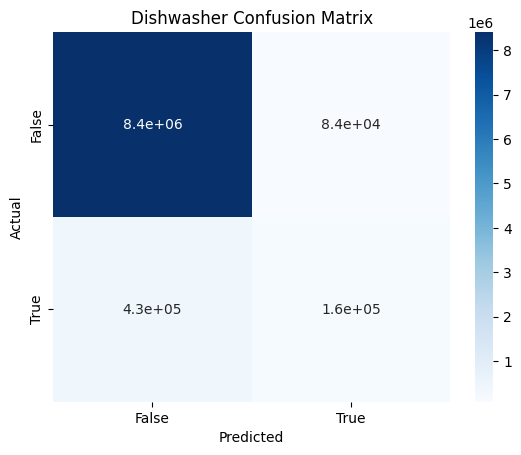

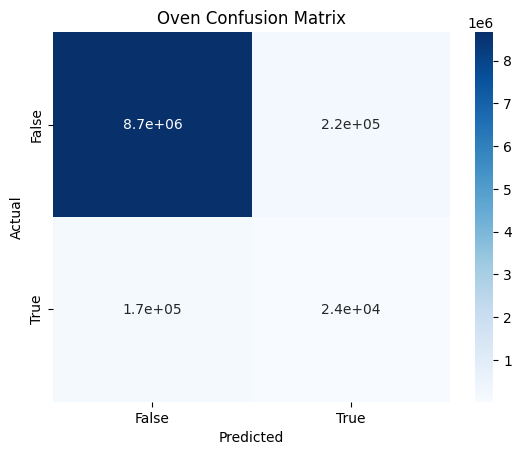

In [ ]:
dishwasher_results = nilm_data["dishwasher_state"] == nilm_data["dishwasher_real"]
oven_results = nilm_data["oven_state"] == nilm_data["oven_real"]

#display confusion matrix of nilm_data["dishwasher_state"] and nilm_data["dishwasher_real"]
confusion_matrix = pd.crosstab(nilm_data["dishwasher_state"], nilm_data["dishwasher_real"], rownames=["Actual"], colnames=["Predicted"])

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", ax=ax)
ax.set_title("Dishwasher Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()
#display confusion matrix of nilm_data["oven_state"] and nilm_data["oven_real"]

confusion_matrix = pd.crosstab(nilm_data["oven_state"], nilm_data["oven_real"], rownames=["Actual"], colnames=["Predicted"])

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", ax=ax)
ax.set_title("Oven Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

In [ ]:
# washing machine results against active appliance only

clf = train_washing()
results = test_suite(clf, nilm_data)
results = [pd.Series(result).value_counts().to_dict() for result in results]
results_df = pd.DataFrame(results)
results_df.index = ["ov_wm", "dw_wm", "ov_dw", "wm", "ov", "dw", "all"]#, "no"]
fig = px.bar(results_df)
fig.update_layout(title="Washing machine results")
fig.show()

results = test_suite(clf, nilm_data)
results = [pd.Series(result).value_counts().to_dict() for result in results]
results_df = pd.DataFrame(results)
results_df.index = ["ov_wm", "dw_wm", "ov_dw", "wm", "ov", "dw", "all"]#, "no"]
px.bar(results_df)